In [63]:
import os
import warnings
from datetime import datetime, timedelta
from typing import Tuple
import seaborn as sn
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from prometheus_api_client import MetricSnapshotDataFrame, MetricRangeDataFrame, PrometheusConnect
from prometheus_api_client.utils import parse_datetime
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5


warnings.filterwarnings('ignore')


load_dotenv()

True

In [65]:
class BtalertIA:
    def __init__(self, last_minutes_importance: int, regressor=None) -> None:
        """
        Args:
            last_minutes_importance (int): The last minutes that matter to foreacasting (context)
        """
        self.prom = PrometheusConnect(
            url=os.getenv('PROMETHEUS_URL'), disable_ssl=True)
        self.regressor = regressor
        if regressor is None:
            self.regressor = RandomForestRegressor(
                max_depth=40,
                n_estimators=3,
                random_state=123,
            )
        self.forecaster = ForecasterAutoreg(
            regressor=self.regressor,
            lags=self.minutes_to_step(last_minutes_importance)
        )
        self.original_dataframe = pd.DataFrame()
        self.data_train = pd.DataFrame()
        self.data_test = pd.DataFrame()
        self.predictions = pd.Series()
        self.value_column = 'value'
        self.timestamp_column = 'timestamp'

    def load_metric_as_dataframe(self, start: str, end: str, metric_name: str, alias: str) -> pd.DataFrame:
        start_time = parse_datetime(start)
        end_time = parse_datetime(end)
        original_dataframe = MetricRangeDataFrame(
            self.prom.custom_query_range(
                query=metric_name, start_time=start_time, end_time=end_time, step=15)
        )[['value']]

        original_dataframe['value'] = [
            float(value) for value in original_dataframe['value']]
        
        original_dataframe.rename(columns={'value': alias}, inplace=True)
        self.value_column = alias

        self.original_dataframe = original_dataframe
        return original_dataframe

    def split_test_train_dataframe(self, minutes_split: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
        steps = self.minutes_to_step(minutes_split)

        self.data_train = self.original_dataframe[:-steps]
        self.data_test = self.original_dataframe[-steps:]

        return self.data_train, self.data_test

    def minutes_to_step(self, min: int) -> int:
        return int((min * 60) / 15)

    def train_model(self) -> None:
        self.forecaster.fit(y=self.data_train[self.value_column])

    def predict(self, minutes_prediction: int) -> pd.Series:
        self.predictions = self.forecaster.predict(steps=self.minutes_to_step(minutes_prediction))
        return self.predictions

    def plot_graphic(self):
        fig, ax = plt.subplots(figsize=(18, 12))
        self.data_train[self.value_column].plot(ax=ax, label='train')
        self.data_test[self.value_column].plot(ax=ax, label='test')
        self.predictions.plot(ax=ax, label='predictions')
        ax.legend()

    def get_mean_squared_error(self) -> float:
        error_mse: float = mean_squared_error(
            y_true=self.data_test[self.value_column],
            y_pred=self.predictions
        )
        return error_mse

    def execute(self, start: str, end: str, metric_name: str, minutes_split: int, minutes_prediction: int, alias: str):
        self.load_metric_as_dataframe(start, end, metric_name, alias)
        self.split_test_train_dataframe(minutes_split)
        self.train_model()
        self.predict(minutes_prediction)
# consts
#start = '2022-05-11 07:50:07'
end = '2022-05-11 10:47:27'
start = '2022-05-11 09:53:16'
#end = '2022-05-11 08:03:53'
min_split = 25
# teste
req_failed_ia = BtalertIA(20)

In [66]:
df = pd.read_csv('data/all_sample.csv', delimiter=';')
df['timestamp'] = [datetime.fromtimestamp(timestamp) for timestamp in df['timestamp']]
df = df.set_index(df['timestamp'])
df = df.asfreq(freq='15S', method='bfill')
df.drop(columns='timestamp', inplace=True)

In [146]:
#start = '2022-05-24 17:39:11'
start = '2022-05-24 18:22:32'
#end = '2022-05-24 18:25:20'
end = '2022-05-24 18:53:30'
req_failed = req_failed_ia.load_metric_as_dataframe(start, end, 'btalert_failed_requests_percent', 'req_failed')
requests_per_second = req_failed_ia.load_metric_as_dataframe(start, end, 'btalert_requests_per_second', 'request_per_sec')
pg_lock_count = req_failed_ia.load_metric_as_dataframe(start, end, 'pg_lock_count{mode="AccessShareLock"}', 'lock_count')
max_cpu = req_failed_ia.load_metric_as_dataframe(start, end, 'max(rate(container_cpu_usage_seconds_total{image="api6-backend_cadastrol-server"}[1m:15s]))', 'cpu_percent')
memory = req_failed_ia.load_metric_as_dataframe(start, end, 'container_memory_rss{name="cadastrol-server"} / container_spec_memory_limit_bytes{name="cadastrol-server"}', 'memory_percent')

In [147]:
res = None
res = pd.concat([req_failed.reset_index(), requests_per_second.reset_index(), pg_lock_count.reset_index(), max_cpu.reset_index(), memory.reset_index()], axis=1)
res = res.iloc[:, np.r_[1, 3, 5, 7, 8, 9]]
res

,req_failed,request_per_sec,lock_count,cpu_percent,timestamp,memory_percent
0,0.00,1.27,3.0,0.172137,1653427352,0.883011
1,54.61,6.47,1.0,0.178774,1653427367,0.840714
2,13.78,3.87,3.0,0.172061,1653427382,0.829636
3,0.00,4.93,9.0,0.219262,1653427397,0.819061
4,99.00,20.00,7.0,0.215624,1653427412,0.792374
...,...,...,...,...,...,...
135,NaN,NaN,NaN,NaN,1653429137,0.866715
136,NaN,NaN,NaN,NaN,1653429152,0.866715
137,NaN,NaN,NaN,NaN,1653429167,0.866715
138,NaN,NaN,NaN,NaN,1653429182,0.866715


In [158]:
res.index = [datetime.fromtimestamp(int(data)) for data in res['timestamp']]
res.index.name = 'timestamp'
res.drop(columns=['timestamp'], inplace=True)
res

,req_failed,request_per_sec,lock_count,cpu_percent,memory_percent,health
timestamp,,,,,,
2022-05-24 18:22:32,0.00,1.27,3.0,0.172137,0.883011,1.0000
2022-05-24 18:22:47,54.61,6.47,1.0,0.178774,0.840714,0.4539
2022-05-24 18:23:02,13.78,3.87,3.0,0.172061,0.829636,0.8622
2022-05-24 18:23:17,0.00,4.93,9.0,0.219262,0.819061,1.0000
2022-05-24 18:23:32,99.00,20.00,7.0,0.215624,0.792374,0.0100
...,...,...,...,...,...,...
2022-05-24 18:52:17,48.64,2.33,1.0,0.000000,0.866715,0.5136
2022-05-24 18:52:32,48.64,2.33,1.0,0.000000,0.866715,0.5136
2022-05-24 18:52:47,48.64,2.33,1.0,0.000000,0.866715,0.5136


In [159]:
res = res[~res.index.duplicated(keep='first')]
res = res.asfreq(freq='15S', method='ffill')
res = res.fillna(method='ffill')
res

,req_failed,request_per_sec,lock_count,cpu_percent,memory_percent,health
timestamp,,,,,,
2022-05-24 18:22:32,0.00,1.27,3.0,0.172137,0.883011,1.0000
2022-05-24 18:22:47,54.61,6.47,1.0,0.178774,0.840714,0.4539
2022-05-24 18:23:02,13.78,3.87,3.0,0.172061,0.829636,0.8622
2022-05-24 18:23:17,0.00,4.93,9.0,0.219262,0.819061,1.0000
2022-05-24 18:23:32,99.00,20.00,7.0,0.215624,0.792374,0.0100
...,...,...,...,...,...,...
2022-05-24 18:52:17,48.64,2.33,1.0,0.000000,0.866715,0.5136
2022-05-24 18:52:32,48.64,2.33,1.0,0.000000,0.866715,0.5136
2022-05-24 18:52:47,48.64,2.33,1.0,0.000000,0.866715,0.5136


In [160]:
res['health'] = res['req_failed'].apply(lambda x: (100 - x) / 100)

In [161]:
res.to_csv('data/new_samples.csv')

In [162]:
df = pd.read_csv('data/new_samples.csv')

In [163]:
df.drop(columns=['lock_count', 'request_per_sec', 'req_failed'], inplace=True)

In [165]:
df.index = [datetime.fromisoformat(data) for data in df['timestamp']]
df.index.name = 'timestamp'
df.drop(columns=['timestamp'], inplace=True)
df

,cpu_percent,memory_percent,health
timestamp,,,
2022-05-24 18:22:32,0.172137,0.883011,1.0000
2022-05-24 18:22:47,0.178774,0.840714,0.4539
2022-05-24 18:23:02,0.172061,0.829636,0.8622
2022-05-24 18:23:17,0.219262,0.819061,1.0000
2022-05-24 18:23:32,0.215624,0.792374,0.0100
...,...,...,...
2022-05-24 18:52:17,0.000000,0.866715,0.5136
2022-05-24 18:52:32,0.000000,0.866715,0.5136
2022-05-24 18:52:47,0.000000,0.866715,0.5136


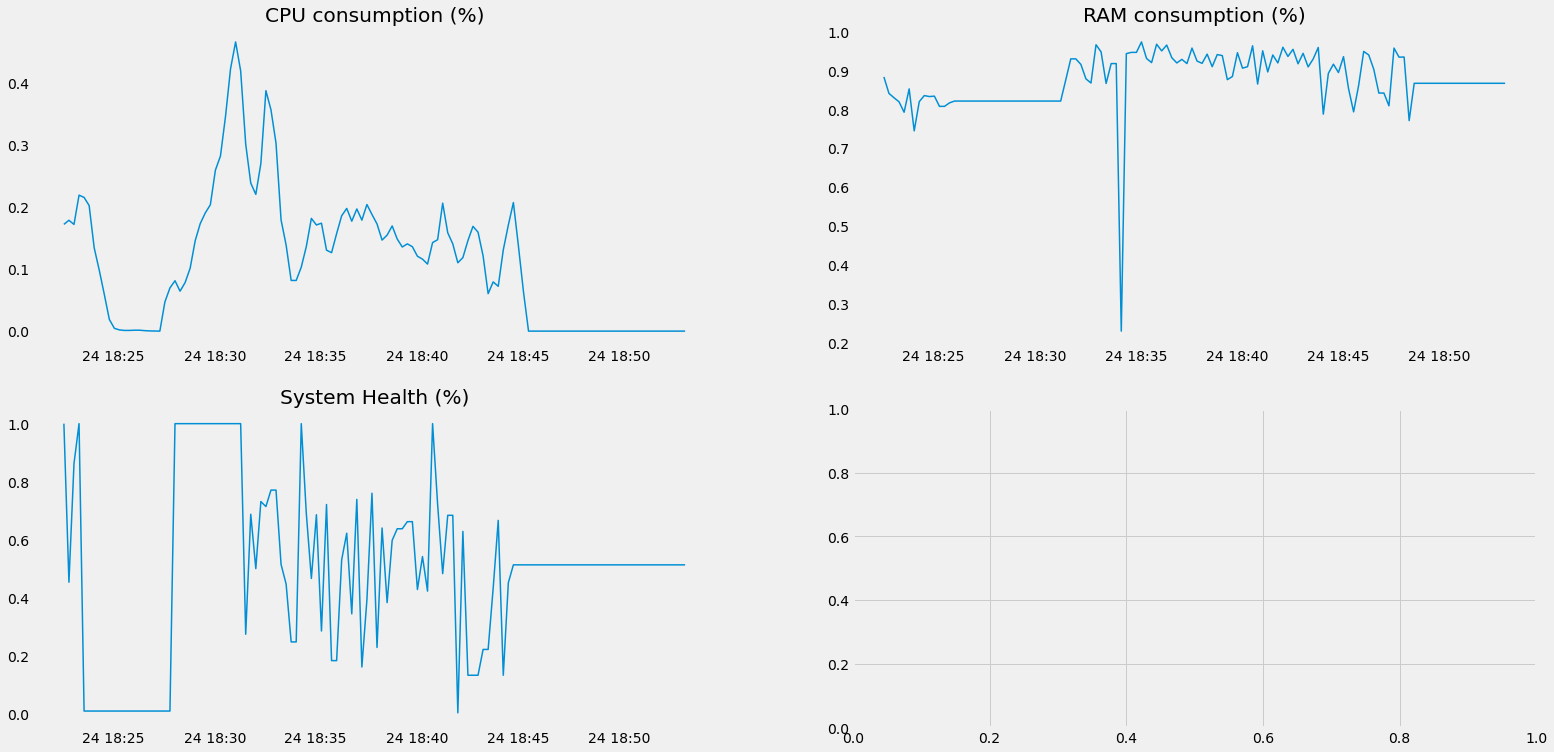

In [166]:
_, ax = plt.subplots(2, 2, figsize=(24, 12))

ax[0][0].set_title('CPU consumption (%)')
ax[0][0].plot(df.cpu_percent)
ax[0][0].grid()

ax[0][1].set_title('RAM consumption (%)')
ax[0][1].plot(df.memory_percent)
ax[0][1].grid()

ax[1][0].set_title('System Health (%)')
ax[1][0].plot(df.health)
ax[1][0].grid()
